均方误差: 0.024354511363830298
R2 分数: 0.4445784221754048


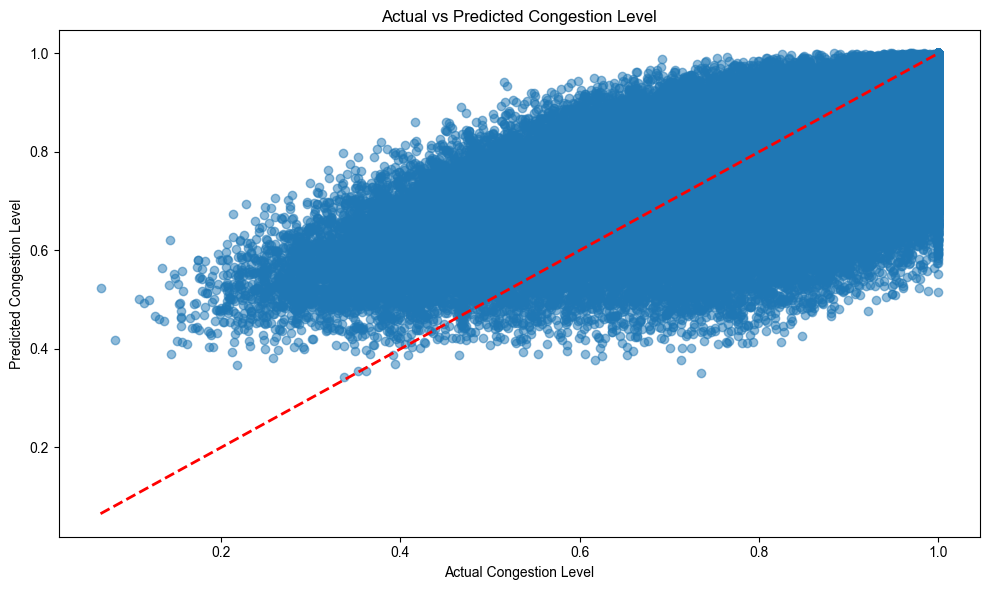

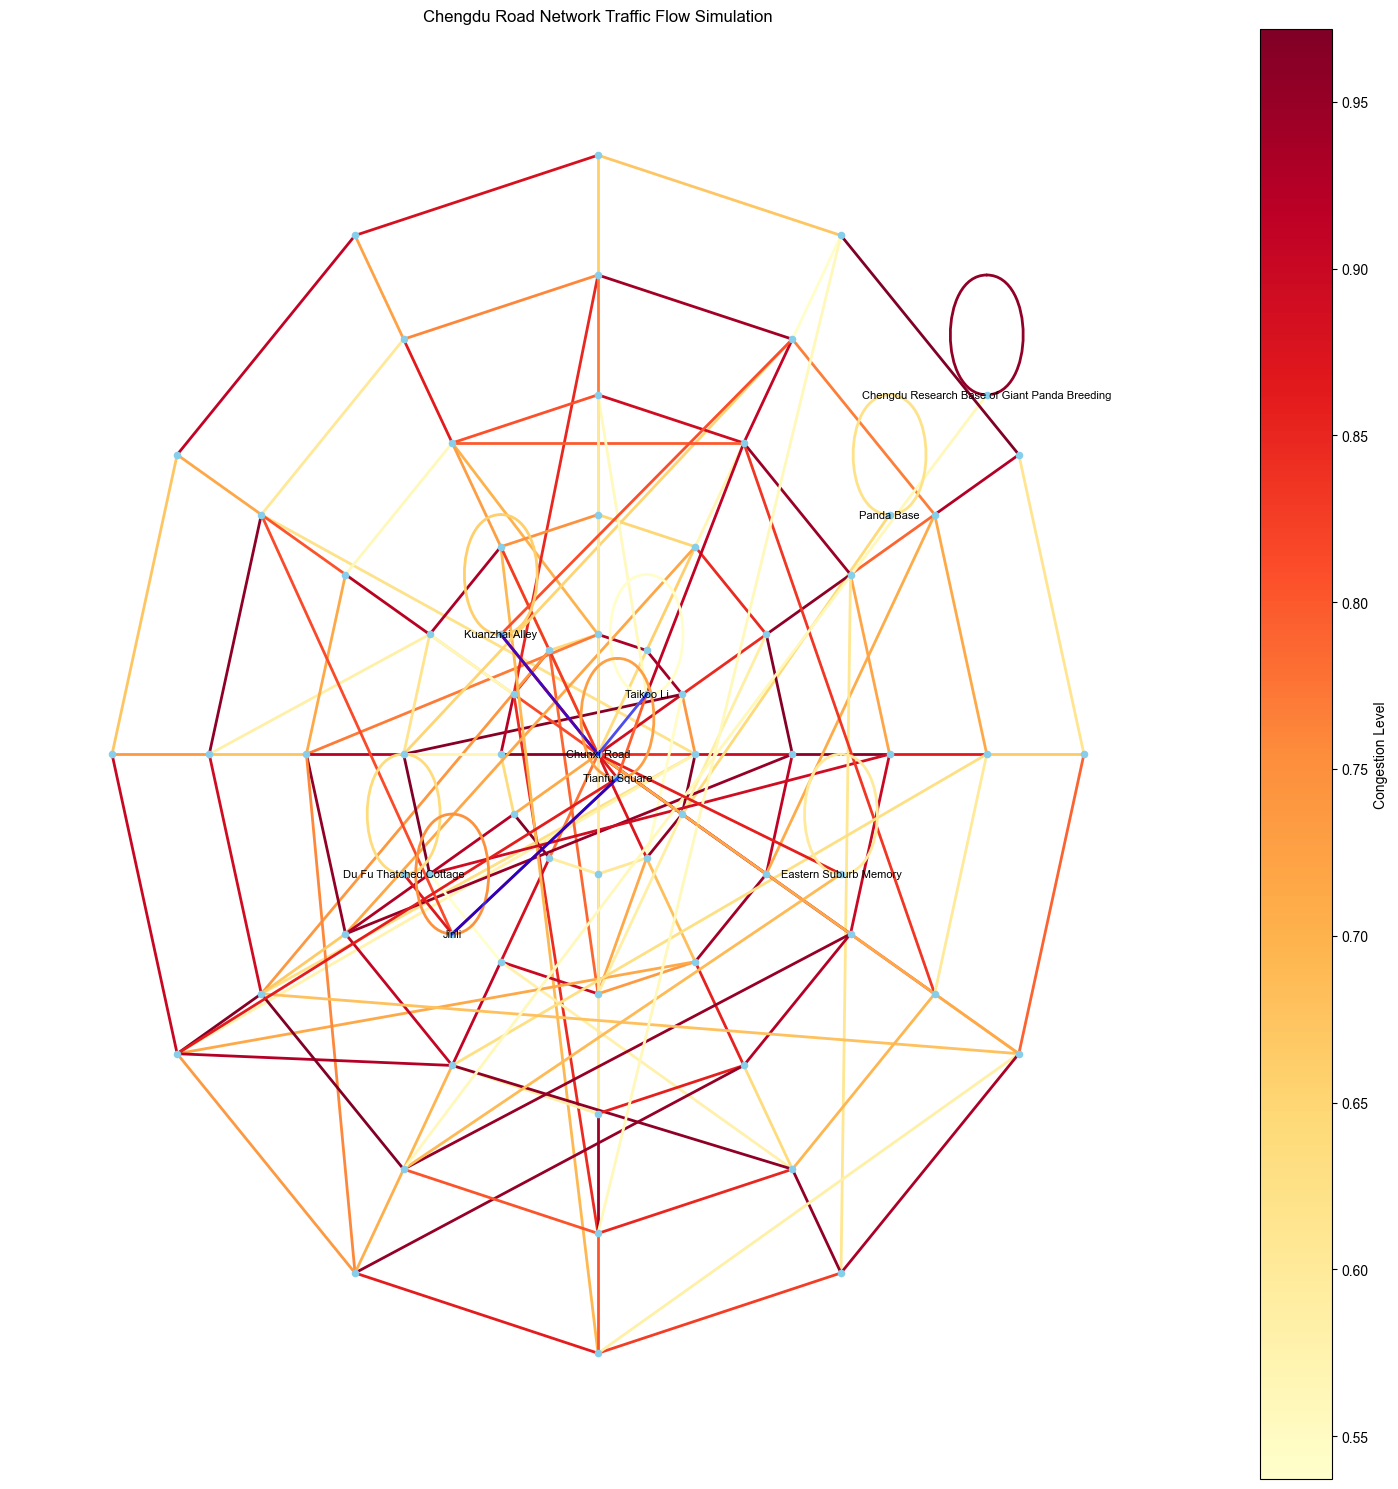

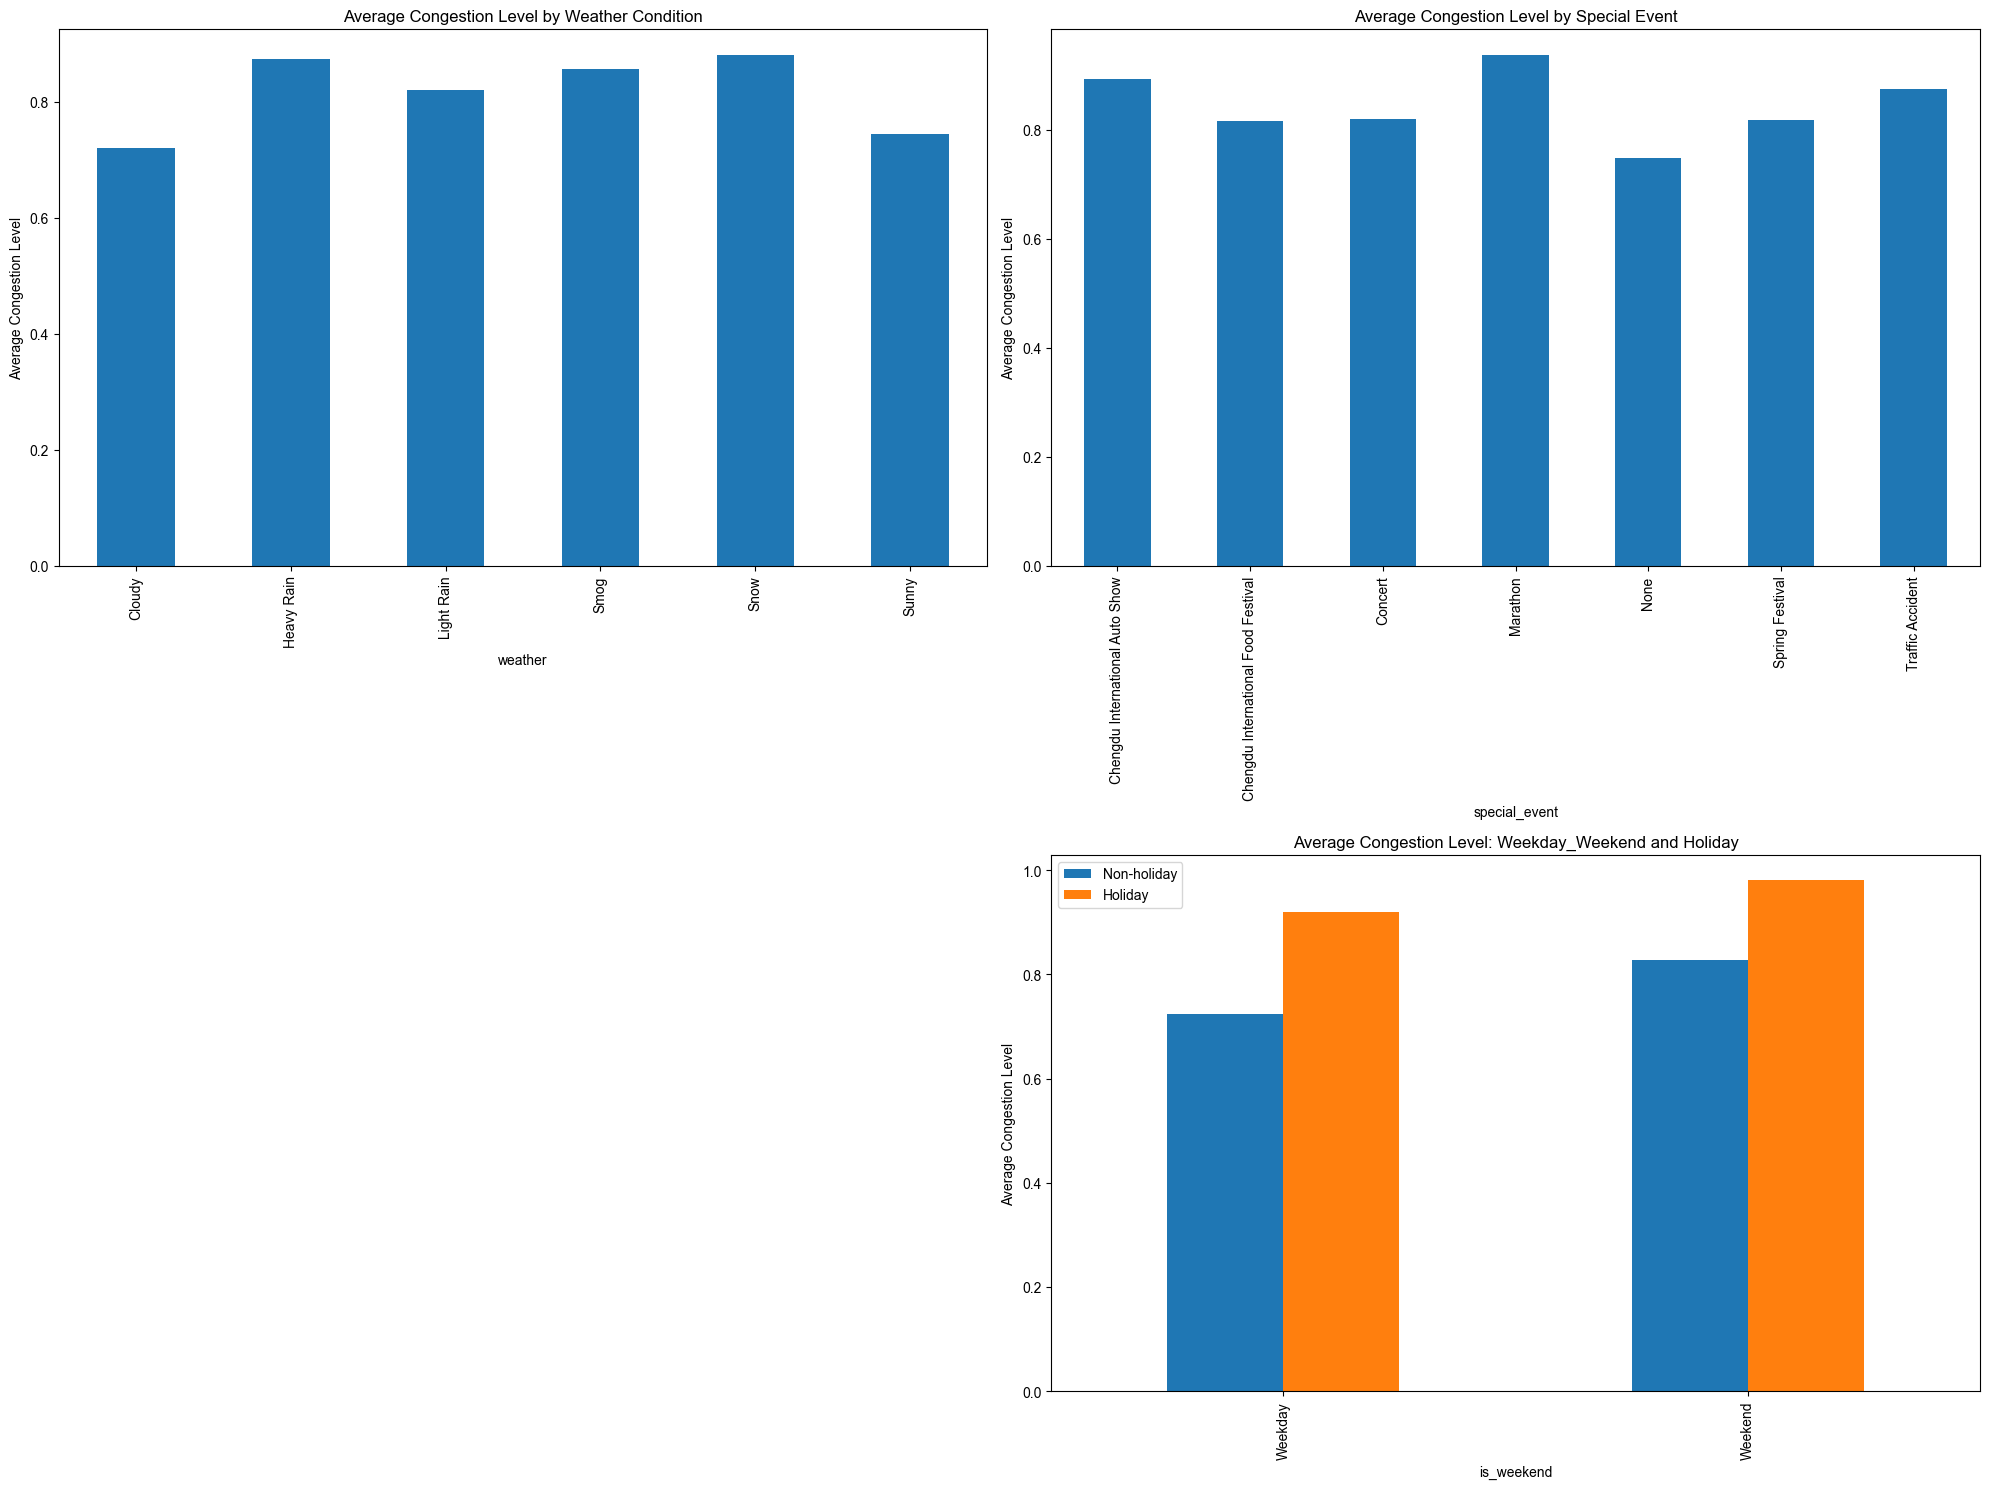

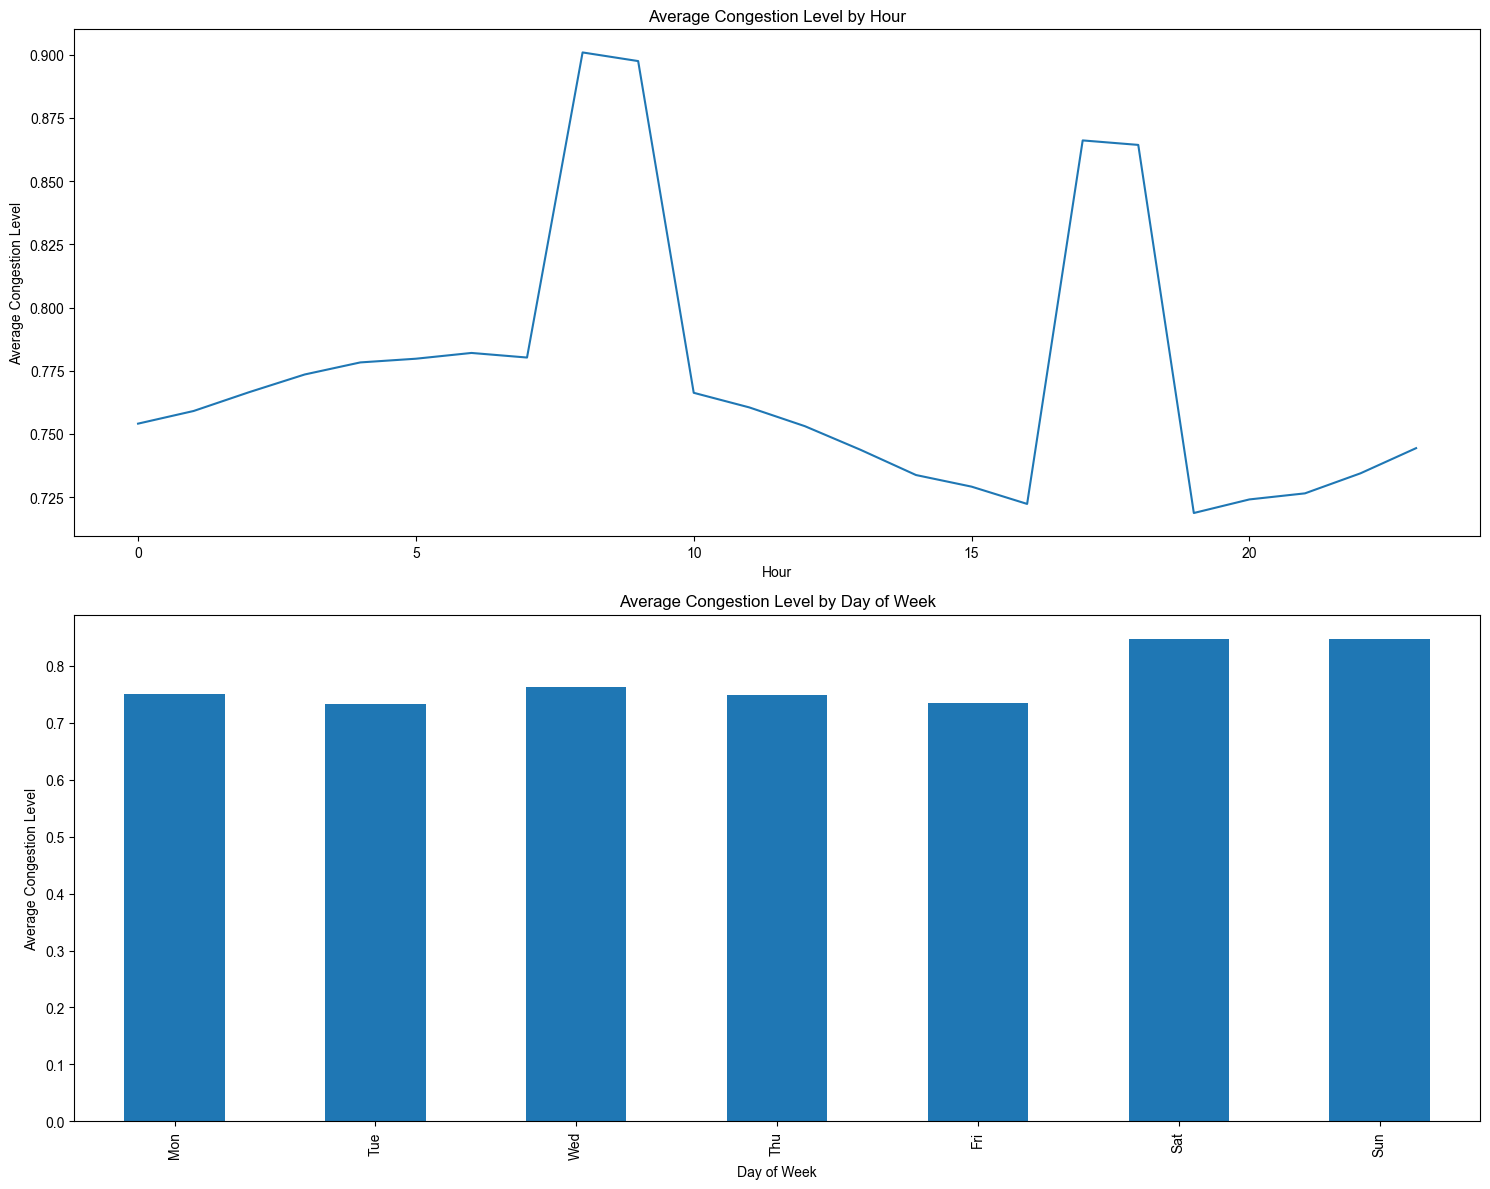


特征重要性:
                 feature  importance
2         traffic_volume    0.352056
1          road_capacity    0.165797
5     population_density    0.099125
4   public_transit_usage    0.098847
3           is_peak_time    0.063242
6                num_poi    0.060866
0                   hour    0.056496
10            is_holiday    0.034272
9             is_weekend    0.027173
7         weather_impact    0.024377
8           event_impact    0.014295
12              is_metro    0.003454
11                season    0.000000


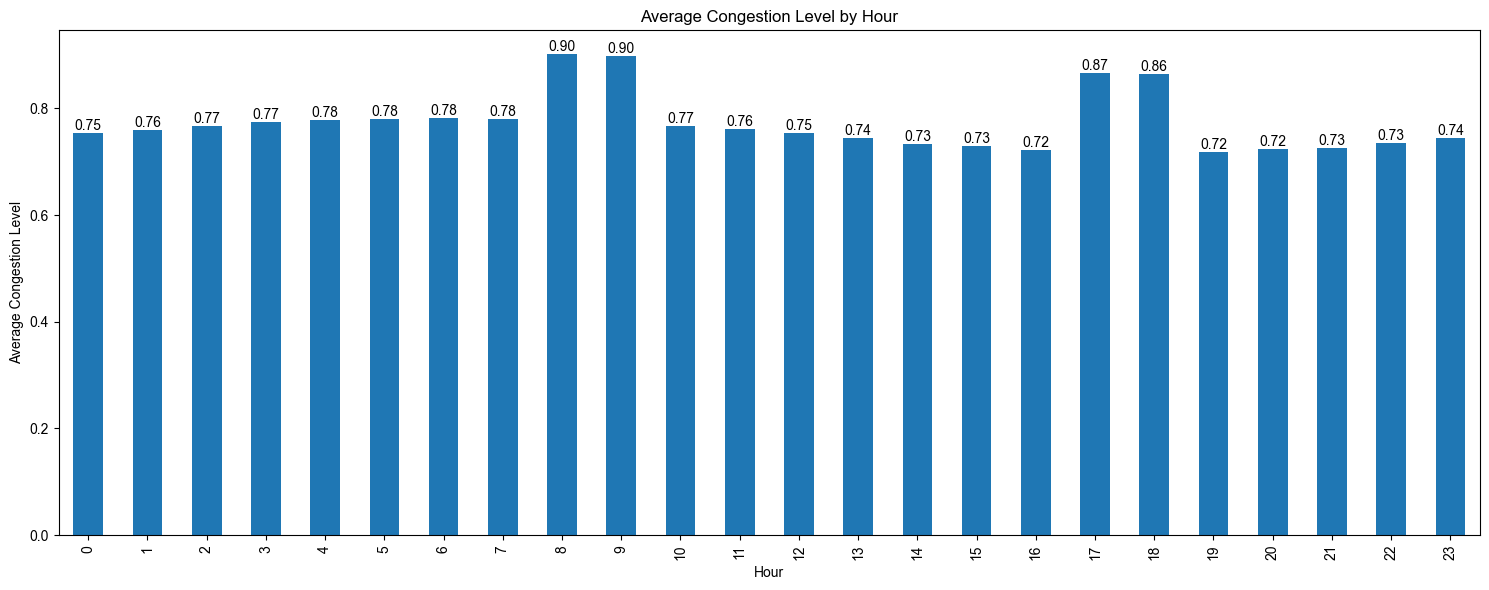

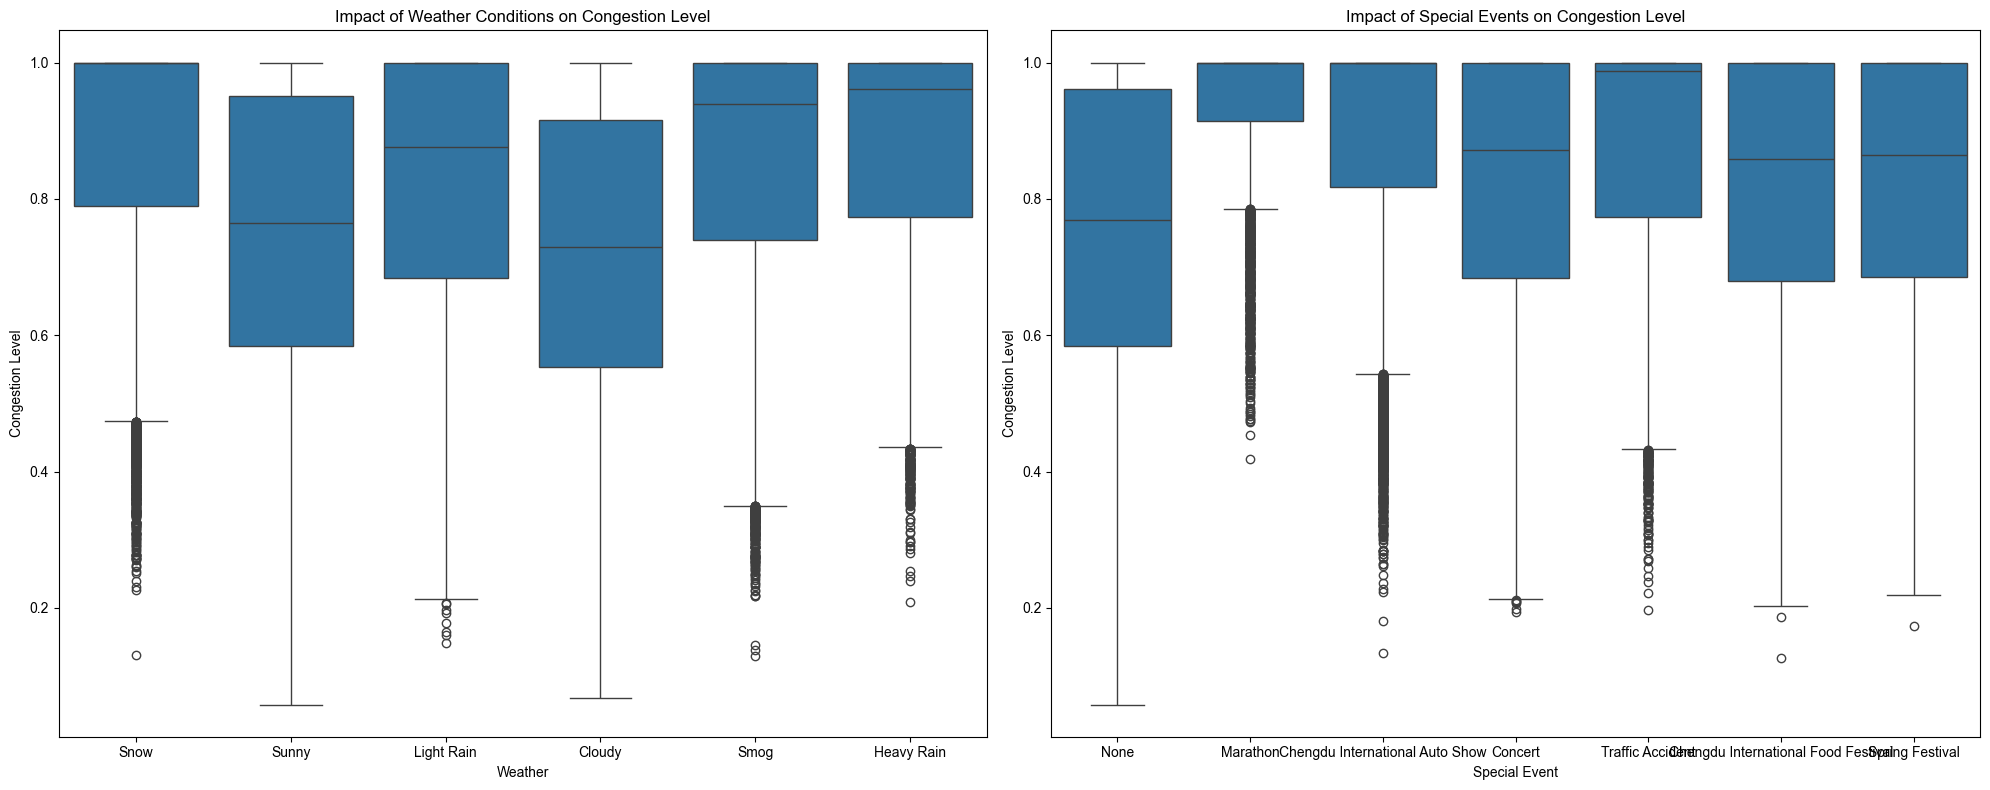

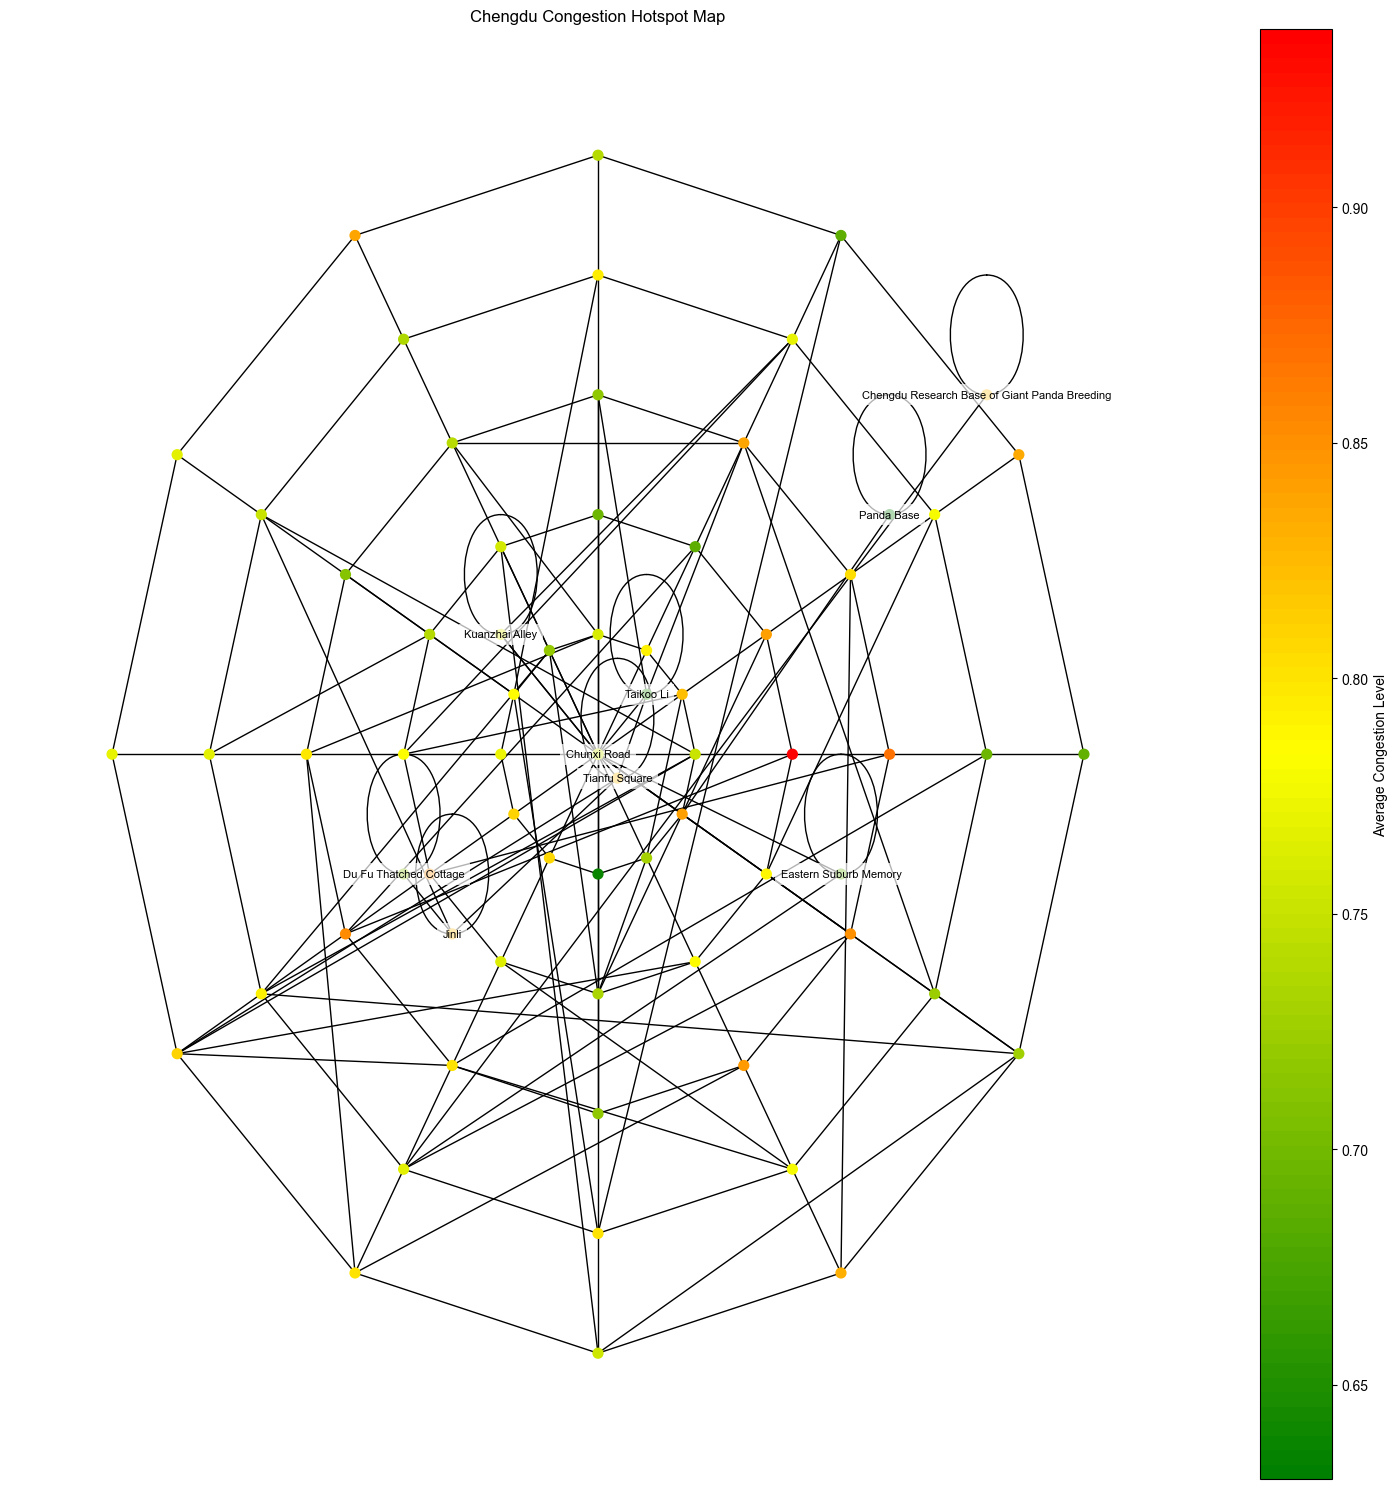

D:\Application\anaconda3\envs\python_3.9\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Application\anaconda3\envs\python_3.9\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
D:\Application\anaconda3\envs\python_3.9\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\81405\AppData\Local\Temp\ipykernel_6500\477377727.py:564: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


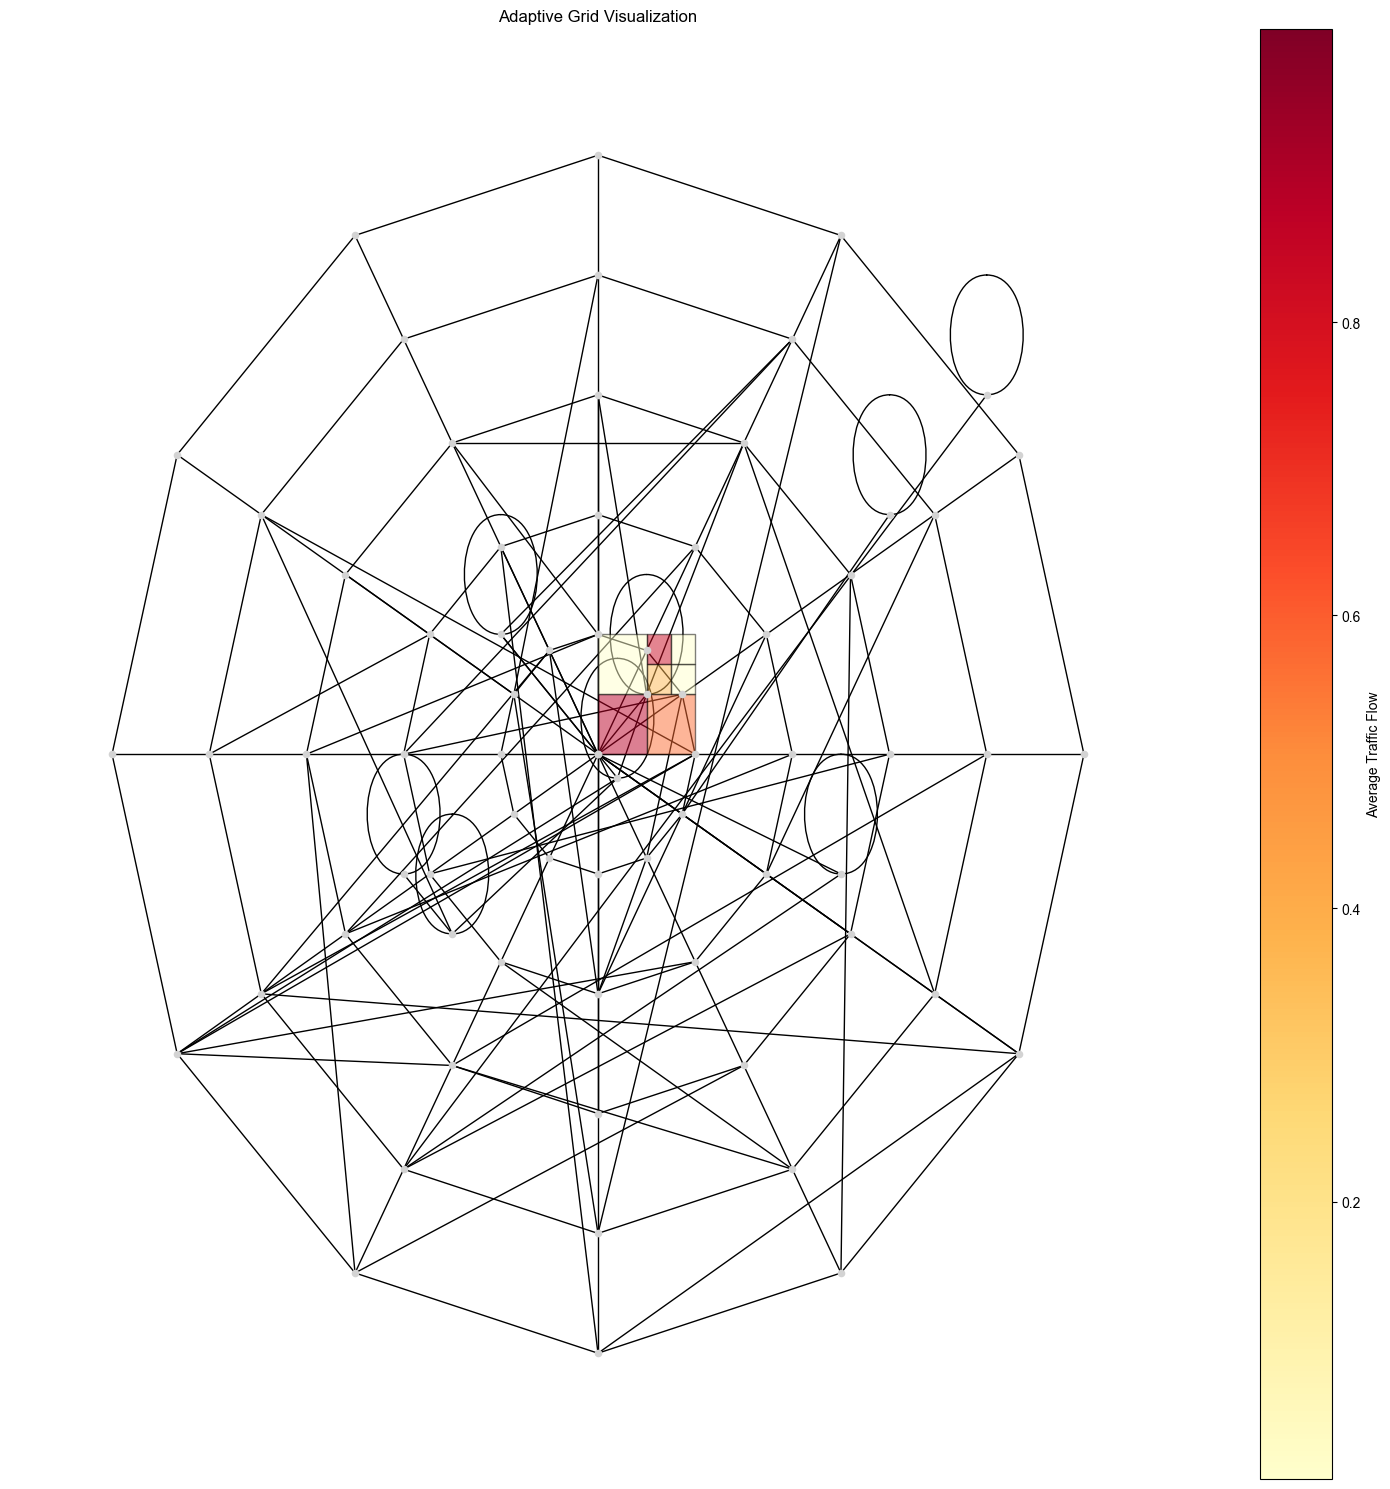

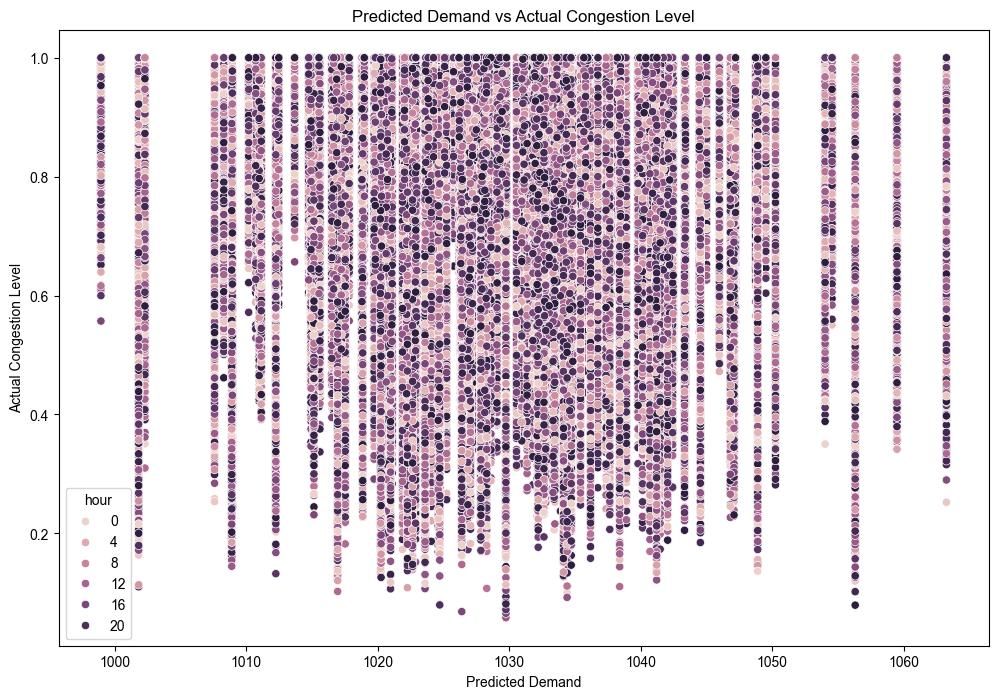

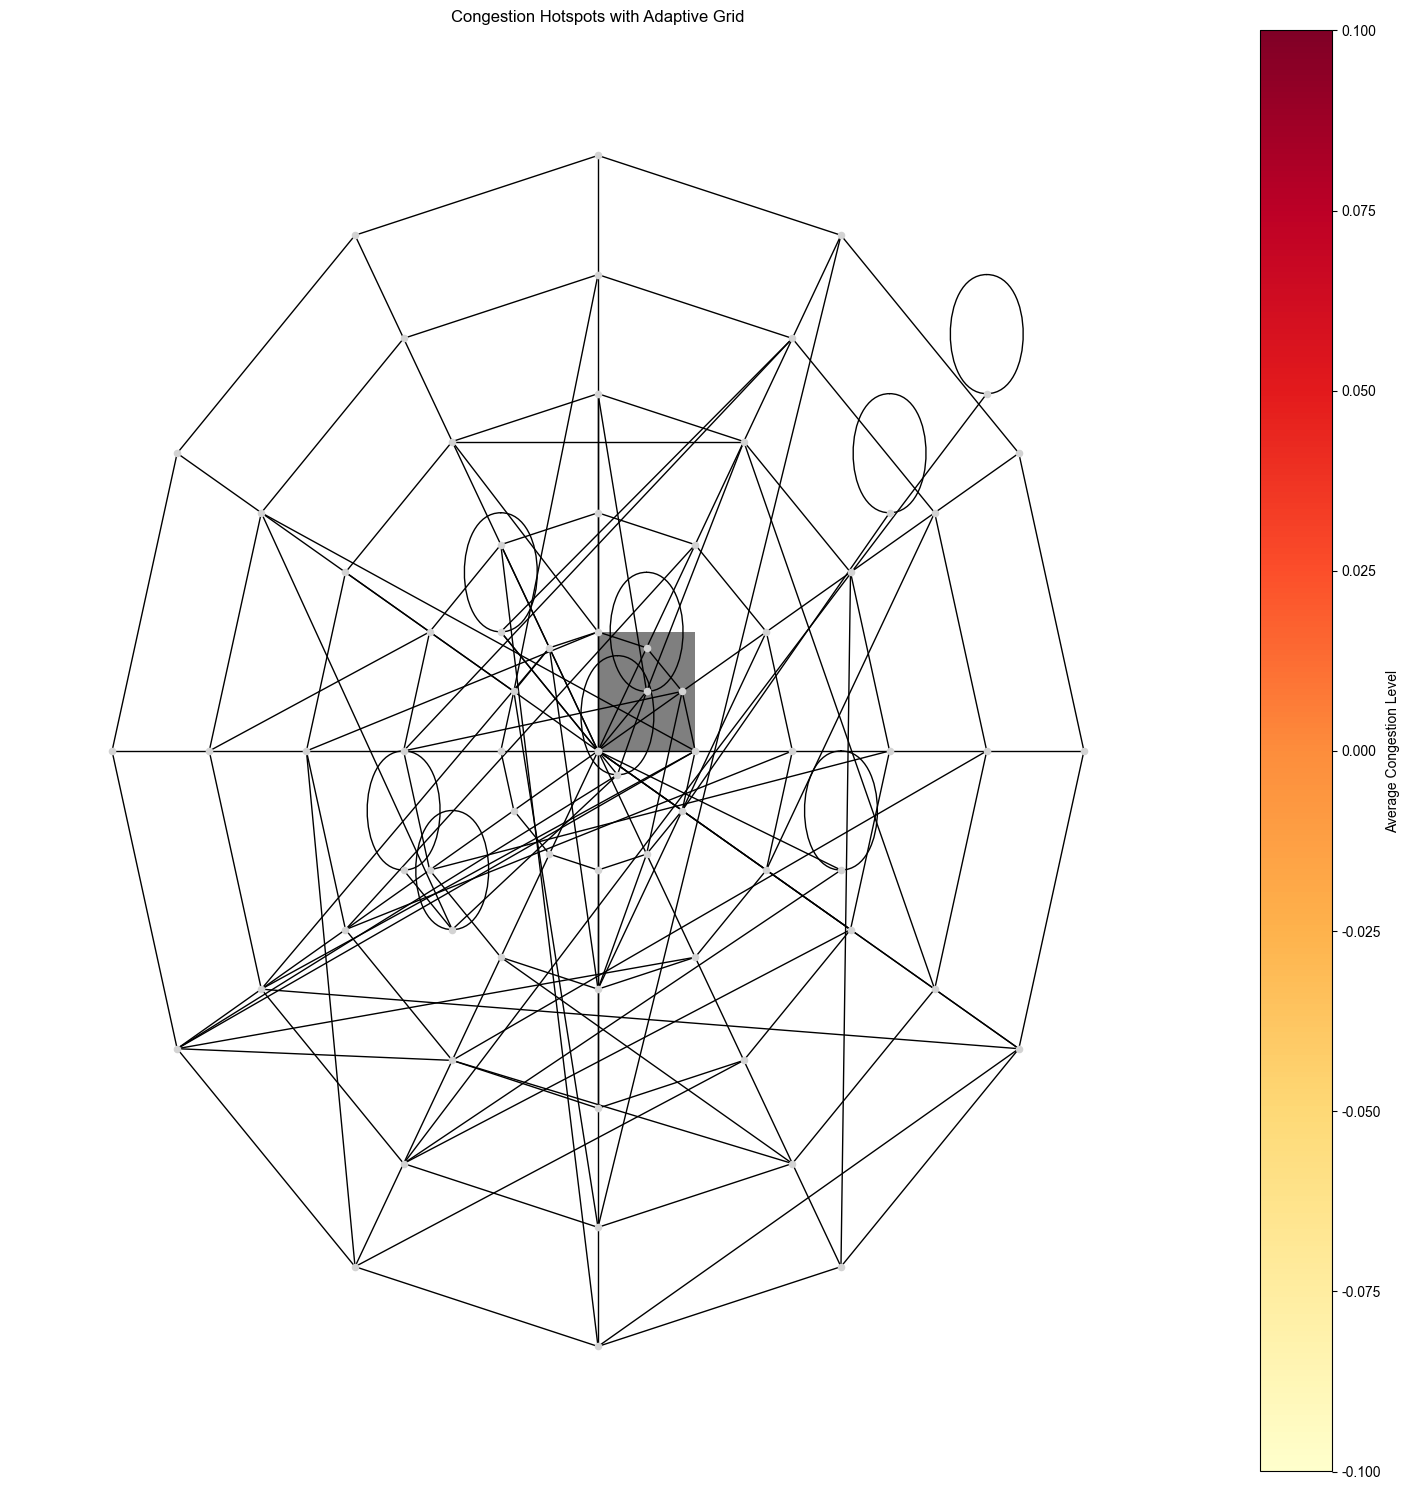

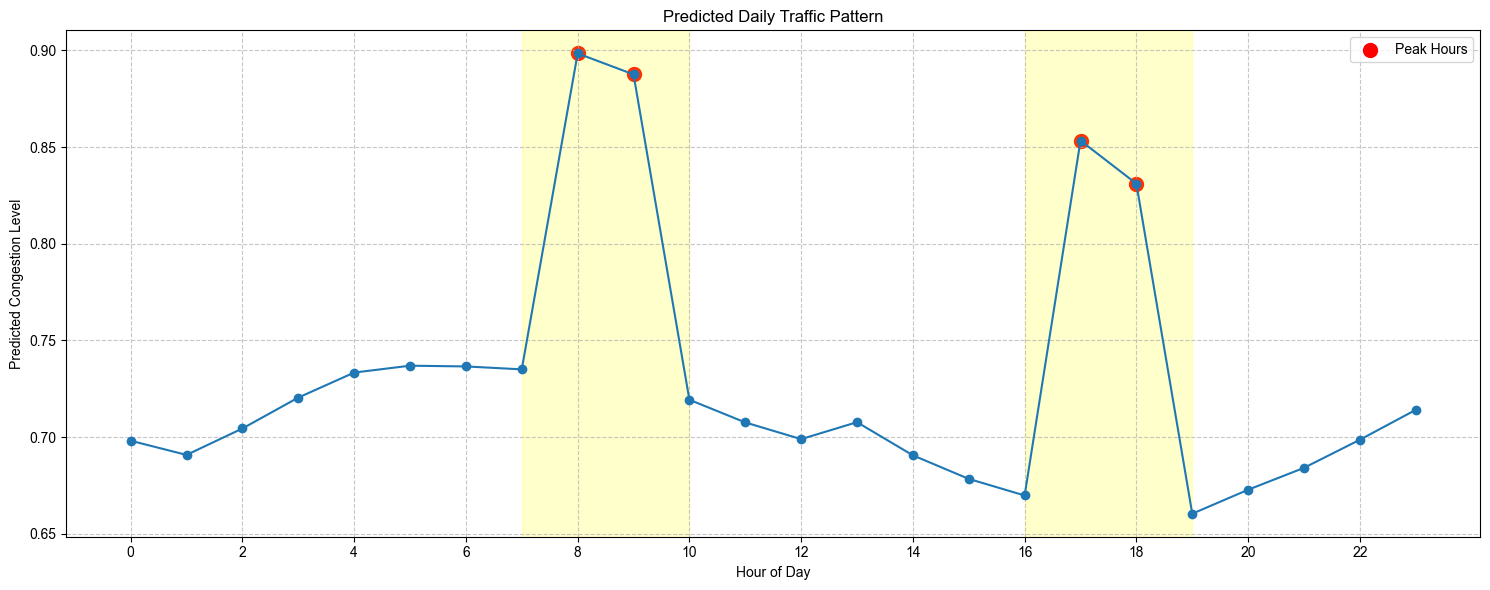

In [12]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.integrate import odeint

#plt.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# 成都市主要地标和商圈
#LANDMARKS = {
  #  '春熙路': (0, 0),
    #'太古里': (0.5, 0.5),
    #'宽窄巷子': (-1, 1),
    #'杜甫草堂': (-2, -1),
    #'锦里': (-1.5, -1.5),
    #'熊猫基地': (3, 2),
    #'天府广场': (0.2, -0.2),
    #'东郊记忆': (2.5, -1),
    #'成都大熊猫繁育研究基地': (4, 3),
#}

# 地铁线路（简化版）
#METRO_LINES = [
  #  [('春熙路', '太古里'), ('太古里', '天府广场')],
   # [('宽窄巷子', '春熙路'), ('春熙路', '东郊记忆')],
    #[('天府广场', '锦里'), ('锦里', '杜甫草堂')],
#]
# Main landmarks and commercial areas in Chengdu
LANDMARKS = {
    'Chunxi Road': (0, 0),
    'Taikoo Li': (0.5, 0.5),
    'Kuanzhai Alley': (-1, 1),
    'Du Fu Thatched Cottage': (-2, -1),
    'Jinli': (-1.5, -1.5),
    'Panda Base': (3, 2),
    'Tianfu Square': (0.2, -0.2),
    'Eastern Suburb Memory': (2.5, -1),
    'Chengdu Research Base of Giant Panda Breeding': (4, 3),
}

# Metro lines (simplified version)
METRO_LINES = [
    [('Chunxi Road', 'Taikoo Li'), ('Taikoo Li', 'Tianfu Square')],
    [('Kuanzhai Alley', 'Chunxi Road'), ('Chunxi Road', 'Eastern Suburb Memory')],
    [('Tianfu Square', 'Jinli'), ('Jinli', 'Du Fu Thatched Cottage')],
]


def generate_chengdu_road_network(n_rings=5, n_radial=12, n_secondary=50):
    G = nx.Graph()
    
    # Add ring roads and radial roads
    for r in range(1, n_rings + 1):
        for i in range(n_radial):
            angle = 2 * np.pi * i / n_radial
            x = r * np.cos(angle)
            y = r * np.sin(angle)
            G.add_node((r, i), pos=(x, y))
            if i > 0:
                G.add_edge((r, i), (r, i-1))
        G.add_edge((r, n_radial-1), (r, 0))
    
    for i in range(n_radial):
        for r in range(1, n_rings):
            G.add_edge((r, i), (r+1, i))
    
    # Add center point (Tianfu Square)
    G.add_node((0, 0), pos=(0, 0))
    for i in range(n_radial):
        G.add_edge((0, 0), (1, i))
    
    # Add landmarks
    for name, pos in LANDMARKS.items():
        G.add_node(name, pos=pos)
        # Connect to closest node
        closest_node = min(G.nodes(), key=lambda n: np.linalg.norm(np.array(G.nodes[n]['pos']) - np.array(pos)) if 'pos' in G.nodes[n] else float('inf'))
        G.add_edge(name, closest_node)
    
    # Add metro lines
    for line in METRO_LINES:
        for start, end in line:
            if start in G.nodes() and end in G.nodes():
                G.add_edge(start, end, is_metro=True)
    
    # Add secondary roads using Python's random choice instead of numpy
    import random
    for _ in range(n_secondary):
        nodes = list(G.nodes())
        try:
            node1, node2 = random.sample(nodes, 2)  # Using random.sample instead of np.random.choice
            if not G.has_edge(node1, node2):
                G.add_edge(node1, node2)
        except ValueError:
            continue  # Skip if we can't find two different nodes
    
    return G

def generate_simulated_data(G, num_days=60):
    np.random.seed(42)
    
    #weather_conditions = ['晴朗', '多云', '小雨', '大雨', '雪', '雾霾']
    #weather_impact = {'晴朗': 0, '多云': 0.1, '小雨': 0.3, '大雨': 0.6, '雪': 0.8, '雾霾': 0.5}
    
    #special_events = ['无', '春节', '成都国际美食节', '成都国际车展', '音乐会', '马拉松比赛', '交通事故']
    #event_impact = {'无': 0, '春节': 0.8, '成都国际美食节': 0.6, '成都国际车展': 0.7, '音乐会': 0.4, '马拉松比赛': 0.5, '交通事故': 0.7}
    
    weather_conditions = ['Sunny', 'Cloudy', 'Light Rain', 'Heavy Rain', 'Snow', 'Smog']
    weather_impact = {'Sunny': 0, 'Cloudy': 0.1, 'Light Rain': 0.3, 'Heavy Rain': 0.6, 'Snow': 0.8, 'Smog': 0.5}

    special_events = ['None', 'Spring Festival', 'Chengdu International Food Festival', 'Chengdu International Auto Show', 'Concert', 'Marathon', 'Traffic Accident']
    event_impact = {'None': 0, 'Spring Festival': 0.8, 'Chengdu International Food Festival': 0.6, 'Chengdu International Auto Show': 0.7, 'Concert': 0.4, 'Marathon': 0.5, 'Traffic Accident': 0.7}

    data = []
    base_congestion = {edge: np.random.uniform(0.2, 0.8) for edge in G.edges()}
    
    for day in range(num_days):
        is_weekend = day % 7 >= 5
        is_holiday = day in [0, 1, 2, 3, 4, 5, 6]  # 假设前7天是春节假期
        season = (day // 90) % 4  # 0: 春, 1: 夏, 2: 秋, 3: 冬
        
        daily_weather = np.random.choice(weather_conditions, p=[0.4, 0.3, 0.1, 0.05, 0.05, 0.1])
        daily_event = np.random.choice(special_events, p=[0.7, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
        
        for hour in range(24):
            for edge in G.edges():
                road_capacity = np.random.randint(500, 2000)
                base_traffic_volume = np.random.randint(100, road_capacity)
                is_peak_time = 1 if (hour in [8, 9, 17, 18]) else 0
                is_metro = G.edges[edge].get('is_metro', False)
                public_transit_usage = np.random.randint(0, 200) * (1.5 if is_metro else 1)
                population_density = np.random.randint(2000, 20000)
                num_poi = np.random.randint(0, 20)
                
                time_factor = 1 + 0.2 * np.sin(2 * np.pi * hour / 24)
                weather_factor = 1 + weather_impact[daily_weather] * np.random.uniform(0.5, 1.5)
                event_factor = 1 + event_impact[daily_event] * np.random.uniform(0.5, 1.5)
                weekend_factor = 1.2 if is_weekend else 1
                holiday_factor = 1.5 if is_holiday else 1
                season_factor = 1 + 0.1 * np.sin(2 * np.pi * season / 4)
                
                traffic_volume = (
                    base_traffic_volume * 
                    time_factor * 
                    weather_factor * 
                    event_factor * 
                    weekend_factor * 
                    holiday_factor * 
                    season_factor
                )
                
                congestion_level = (
                    base_congestion[edge] +
                    0.3 * (traffic_volume / road_capacity) +
                    0.2 * is_peak_time +
                    0.01 * (population_density / 10000) -
                    0.05 * (public_transit_usage / 100) +
                    0.02 * (num_poi / 10) +
                    0.1 * weather_impact[daily_weather] +
                    0.1 * event_impact[daily_event] +
                    0.1 * (1 if is_weekend else 0) +
                    0.2 * (1 if is_holiday else 0) +
                    0.05 * np.sin(2 * np.pi * season / 4) +
                    np.random.normal(0, 0.05)
                )
                congestion_level = max(0, min(congestion_level, 1))
                
                data.append([day, hour, edge, road_capacity, traffic_volume, 
                             is_peak_time, public_transit_usage, population_density, 
                             num_poi, daily_weather, daily_event, is_weekend, is_holiday,
                             season, is_metro, congestion_level])
    
    columns = ['day', 'hour', 'edge', 'road_capacity', 'traffic_volume', 
               'is_peak_time', 'public_transit_usage', 'population_density', 
               'num_poi', 'weather', 'special_event', 'is_weekend', 'is_holiday',
               'season', 'is_metro', 'congestion_level']
    
    return pd.DataFrame(data, columns=columns)

def prepare_data(df):
    #df['weather_impact'] = df['weather'].map({'晴朗': 0, '多云': 0.1, '小雨': 0.3, '大雨': 0.6, '雪': 0.8, '雾霾': 0.5})
    #df['event_impact'] = df['special_event'].map({'无': 0, '春节': 0.8, '成都国际美食节': 0.6, '成都国际车展': 0.7, '音乐会': 0.4, '马拉松比赛': 0.5, '交通事故': 0.7})
    df['weather_impact'] = df['weather'].map({'Sunny': 0, 'Cloudy': 0.1, 'Light Rain': 0.3, 'Heavy Rain': 0.6, 'Snow': 0.8, 'Smog': 0.5})
    df['event_impact'] = df['special_event'].map({'None': 0, 'Spring Festival': 0.8, 'Chengdu International Food Festival': 0.6, 'Chengdu International Auto Show': 0.7, 'Concert': 0.4, 'Marathon': 0.5, 'Traffic Accident': 0.7})

    features = ['hour', 'road_capacity', 'traffic_volume', 'is_peak_time', 
                'public_transit_usage', 'population_density', 'num_poi',
                'weather_impact', 'event_impact', 'is_weekend', 'is_holiday',
                'season', 'is_metro']
    X = df[features]
    y = df['congestion_level']
    return train_test_split(X, y, test_size=0.2, random_state=42)

def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, r2, predictions

def visualize_results(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    #plt.xlabel('实际拥堵程度')
    #plt.ylabel('预测拥堵程度')
    #plt.title('实际vs预测拥堵程度')
    plt.xlabel('Actual Congestion Level')
    plt.ylabel('Predicted Congestion Level')
    plt.title('Actual vs Predicted Congestion Level')
    plt.tight_layout()
    plt.show()
#     plt.savefig('actual_vs_predicted_congestion.png', dpi=300, bbox_inches='tight')
#     plt.close()
    

def visualize_network(G, congestion_levels):
    pos = nx.get_node_attributes(G, 'pos')
    fig, ax = plt.subplots(figsize=(15, 15))
    edges = list(G.edges())
    edge_colors = [congestion_levels.get(e, 0) for e in edges]
    
    nx.draw(G, pos, ax=ax, node_size=20, node_color='skyblue', with_labels=False, 
            edge_color=edge_colors, edge_cmap=plt.cm.YlOrRd, width=2)
    
    # 添加地标标签
    for node, (x, y) in pos.items():
        if isinstance(node, str):  # 假设只有地标是字符串
            plt.text(x, y, node, fontsize=8, ha='center', va='center')
    
    # 绘制地铁线路
    for line in METRO_LINES:
        x_coords, y_coords = zip(*[pos[station] for station in line[0]])
        plt.plot(x_coords, y_coords, color='blue', linewidth=2, alpha=0.7)
    
    sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
    sm.set_array([])
    #cbar = plt.colorbar(sm, ax=ax, label='拥堵程度')
    cbar = plt.colorbar(sm, ax=ax, label='Congestion Level')    

    #plt.title('成都市道路网络交通流量模拟')
    plt.title('Chengdu Road Network Traffic Flow Simulation')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
#     plt.savefig('成都市道路网络交通流量模拟.png', dpi=300, bbox_inches='tight')
#     plt.close()
    
    
def analyze_external_factors(df):
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    df.groupby('weather')['congestion_level'].mean().plot(kind='bar', ax=axes[0, 0])
    #axes[0, 0].set_title('不同天气条件下的平均拥堵程度')
    #axes[0, 0].set_ylabel('平均拥堵程度')
    axes[0, 0].set_title('Average Congestion Level by Weather Condition')
    axes[0, 0].set_ylabel('Average Congestion Level')    

    df.groupby('special_event')['congestion_level'].mean().plot(kind='bar', ax=axes[0, 1])
    #axes[0, 1].set_title('不同特殊事件下的平均拥堵程度')
    #axes[0, 1].set_ylabel('平均拥堵程度')
    axes[0, 1].set_title('Average Congestion Level by Special Event')
    axes[0, 1].set_ylabel('Average Congestion Level')
    
    df.groupby(['is_weekend', 'is_holiday'])['congestion_level'].mean().unstack().plot(kind='bar', ax=axes[1, 1])
    #axes[1, 1].set_title('工作日/周末和节假日的平均拥堵程度')
    #axes[1, 1].set_ylabel('平均拥堵程度')
    #axes[1, 1].set_xticklabels(['工作日', '周末'])
    #axes[1, 1].legend(['非节假日', '节假日'])
    axes[1, 1].set_title('Average Congestion Level: Weekday_Weekend and Holiday')
    axes[1, 1].set_ylabel('Average Congestion Level')
    axes[1, 1].set_xticklabels(['Weekday', 'Weekend'])
    axes[1, 1].legend(['Non-holiday', 'Holiday'])

    axes[1, 0].set_visible(False)
    plt.tight_layout()
    plt.show()
#     plt.savefig('工作日_周末和节假日的平均拥堵程度.png', dpi=300, bbox_inches='tight')
#     plt.close()
    

def analyze_time_patterns(df):
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # 分析一天中的交通模式
    df.groupby('hour')['congestion_level'].mean().plot(ax=axes[0])
    #axes[0].set_title('一天中的平均拥堵程度变化')
    #axes[0].set_xlabel('小时')
    #axes[0].set_ylabel('平均拥堵程度')
    axes[0].set_title('Average Congestion Level by Hour')
    axes[0].set_xlabel('Hour')
    axes[0].set_ylabel('Average Congestion Level')

    # 分析一周中的交通模式
    df['day_of_week'] = df['day'] % 7
    #day_names = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    df.groupby('day_of_week')['congestion_level'].mean().plot(kind='bar', ax=axes[1])
    #axes[1].set_title('一周中的平均拥堵程度变化')
    #axes[1].set_xlabel('星期')
    #axes[1].set_ylabel('平均拥堵程度')
    axes[1].set_title('Average Congestion Level by Day of Week')
    axes[1].set_xlabel('Day of Week')
    axes[1].set_ylabel('Average Congestion Level')
    axes[1].set_xticklabels(day_names)
    
    plt.tight_layout()
    plt.show()
#     plt.savefig('一周中的平均拥堵程度变化.png', dpi=300, bbox_inches='tight')
#     plt.close()
    
def predict_future_traffic(model, df):
    """
    Predict future traffic conditions based on historical data.
    
    Parameters:
    model: trained RandomForestRegressor model
    df: historical traffic data DataFrame
    
    Returns:
    DataFrame with future traffic predictions
    """
    future_df = pd.DataFrame()
    
    # Get all unique features used in training
    features = ['hour', 'road_capacity', 'traffic_volume', 'is_peak_time', 
                'public_transit_usage', 'population_density', 'num_poi',
                'weather_impact', 'event_impact', 'is_weekend', 'is_holiday',
                'season', 'is_metro']
    
    for hour in range(24):
        for edge in df['edge'].unique():
            # Get average values for this hour and edge
            edge_data = df[(df['hour'] == hour) & (df['edge'] == edge)]
            if len(edge_data) == 0:
                continue
                
            # Create base row with averages
            row = {}
            
            # Basic temporal features
            row['hour'] = hour
            row['is_peak_time'] = 1 if hour in [8, 9, 17, 18] else 0
            row['is_weekend'] = edge_data['is_weekend'].mode().iloc[0]
            row['is_holiday'] = edge_data['is_holiday'].mode().iloc[0]
            row['season'] = edge_data['season'].mode().iloc[0]
            
            # Infrastructure features
            row['road_capacity'] = edge_data['road_capacity'].mean()
            row['is_metro'] = edge_data['is_metro'].mode().iloc[0]
            
            # Traffic features
            row['traffic_volume'] = edge_data['traffic_volume'].mean()
            row['public_transit_usage'] = edge_data['public_transit_usage'].mean()
            
            # Demographic features
            row['population_density'] = edge_data['population_density'].mean()
            row['num_poi'] = edge_data['num_poi'].mean()
            
            # External factors
            row['weather_impact'] = edge_data['weather_impact'].mean()
            row['event_impact'] = edge_data['event_impact'].mean()
            
            # Prepare features for prediction
            X = pd.DataFrame([row])[features]
            
            # Make prediction
            future_congestion = model.predict(X)[0]
            
            # Add prediction and metadata to row
            row['edge'] = edge
            row['predicted_congestion'] = future_congestion
            
            # Append to future DataFrame
            future_df = pd.concat([future_df, pd.DataFrame([row])], ignore_index=True)
    
    return future_df

def visualize_future_prediction(future_df):
    """
    Visualize predicted traffic patterns.
    
    Parameters:
    future_df: DataFrame containing future predictions
    """
    plt.figure(figsize=(15, 6))
    
    # Calculate average congestion by hour
    hourly_avg = future_df.groupby('hour')['predicted_congestion'].mean()
    
    # Plot the predictions
    plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
    
    # Add peak time highlights
    peak_hours = [8, 9, 17, 18]
    peak_congestion = hourly_avg[peak_hours]
    plt.scatter(peak_hours, peak_congestion, color='red', s=100, label='Peak Hours')
    
    plt.title('Predicted Daily Traffic Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Predicted Congestion Level')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Add time period labels
    plt.axvspan(7, 10, alpha=0.2, color='yellow', label='Morning Rush')
    plt.axvspan(16, 19, alpha=0.2, color='yellow', label='Evening Rush')
    
    plt.xticks(range(0, 24, 2))
    plt.tight_layout()
    plt.show()  

def analyze_hourly_congestion(df):
    plt.figure(figsize=(15, 6))
    hourly_congestion = df.groupby('hour')['congestion_level'].mean()
    hourly_congestion.plot(kind='bar')
    #plt.title('每小时平均拥堵程度')
    #plt.xlabel('小时')
    #plt.ylabel('平均拥堵程度')
    plt.title('Average Congestion Level by Hour')
    plt.xlabel('Hour')
    plt.ylabel('Average Congestion Level')
    for i, v in enumerate(hourly_congestion):
        plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
#     plt.savefig('每小时平均拥堵程度.png', dpi=300, bbox_inches='tight')
#     plt.close()
    

def analyze_weather_and_events_impact(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    sns.boxplot(x='weather', y='congestion_level', data=df, ax=ax1)
    #ax1.set_title('不同天气条件对拥堵程度的影响')
    #ax1.set_xlabel('天气')
    #ax1.set_ylabel('拥堵程度')
    ax1.set_title('Impact of Weather Conditions on Congestion Level')
    ax1.set_xlabel('Weather')
    ax1.set_ylabel('Congestion Level')
    
    sns.boxplot(x='special_event', y='congestion_level', data=df, ax=ax2)
    #ax2.set_title('特殊事件对拥堵程度的影响')
    #ax2.set_xlabel('特殊事件')
    #ax2.set_ylabel('拥堵程度')
    ax2.set_title('Impact of Special Events on Congestion Level')
    ax2.set_xlabel('Special Event')
    ax2.set_ylabel('Congestion Level')    

    plt.tight_layout()
    plt.show()
#     plt.savefig('天气和特殊事件对拥堵程度的影响.png', dpi=300, bbox_inches='tight')
#     plt.close()
    

def sir_congestion_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# def simulate_congestion_spread(G, initial_congested_nodes, beta=0.3, gamma=0.1, duration=24):
#     N = len(G.nodes())
#     I0 = len(initial_congested_nodes) / N
#     S0 = 1 - I0
#     R0 = 0
    
#     t = np.linspace(0, duration, duration)
#     solution = odeint(sir_congestion_model, [S0, I0, R0], t, args=(beta, gamma))
#     S, I, R = solution.T
    
#     congestion_levels = pd.DataFrame(index=G.nodes(), columns=range(duration))
#     for node in G.nodes():
#         if node in initial_congested_nodes:
#             congestion_levels.loc[node] = I
#         else:
#             congestion_levels.loc[node] = S0 - S
    
#     return congestion_levels
def simulate_congestion_spread(G, initial_congested_nodes, beta=0.3, gamma=0.1, duration=24):
    N = len(G.nodes())
    I0 = len(initial_congested_nodes) / N
    S0 = 1 - I0
    R0 = 0
    
    t = np.linspace(0, duration, duration)
    solution = odeint(sir_congestion_model, [S0, I0, R0], t, args=(beta, gamma))
    S, I, R = solution.T
    
    congestion_levels = pd.DataFrame(index=list(G.nodes()), columns=range(duration))
    
    for node in G.nodes():
        if node in initial_congested_nodes:
            congestion_levels.loc[node] = I
        else:
            congestion_levels.loc[node] = S0 - S
    
    return congestion_levels

def select_initial_congested_nodes(G, num_nodes=5):
    nodes_list = list(G.nodes())
    import random
    
    num_nodes = min(num_nodes, len(nodes_list))
    
    return random.sample(nodes_list, num_nodes)

def predict_traffic_demand(df, poi_data, population_data, economic_data):
    X = pd.concat([poi_data, population_data, economic_data], axis=1)
    y = df.groupby('edge')['traffic_volume'].mean()
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    return model.predict(X)

def adaptive_grid_partition(G, traffic_flow, threshold=0.1):
    def split_cell(cell):
        x, y, w, h = cell
        return [
            (x, y, w/2, h/2),
            (x+w/2, y, w/2, h/2),
            (x, y+h/2, w/2, h/2),
            (x+w/2, y+h/2, w/2, h/2)
        ]
    
    cells = [(0, 0, 1, 1)]  # 初始单元格覆盖整个区域
    while True:
        new_cells = []
        for cell in cells:
            nodes_in_cell = [node for node in G.nodes() if cell[0] <= G.nodes[node]['pos'][0] < cell[0]+cell[2] and cell[1] <= G.nodes[node]['pos'][1] < cell[1]+cell[3]]
            flow_variation = np.std([traffic_flow[node] for node in nodes_in_cell])
            if flow_variation > threshold and len(nodes_in_cell) > 1:
                new_cells.extend(split_cell(cell))
            else:
                new_cells.append(cell)
        if len(new_cells) == len(cells):
            break
        cells = new_cells
    
    return cells

def visualize_adaptive_grid(G, cells, traffic_flow):
    # 创建一个图形和一个主要的 Axes 对象
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # 绘制网络
    nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size=20, node_color='lightgray', with_labels=False, ax=ax)
    
    # 创建一个颜色映射
    cmap = plt.cm.get_cmap('YlOrRd')
    norm = plt.Normalize(vmin=min(traffic_flow.values()), vmax=max(traffic_flow.values()))
    
    # 绘制网格并为每个单元格上色
    for cell in cells:
        x, y, w, h = cell
        nodes_in_cell = [node for node in G.nodes() if x <= G.nodes[node]['pos'][0] < x+w and y <= G.nodes[node]['pos'][1] < y+h]
        cell_flow = sum(traffic_flow[node] for node in nodes_in_cell) / len(nodes_in_cell) if nodes_in_cell else 0
        color = cmap(norm(cell_flow))
        ax.add_patch(plt.Rectangle((x, y), w, h, fill=True, facecolor=color, edgecolor='black', alpha=0.5))
    
    # 创建一个 ScalarMappable 对象用于颜色条
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    # 添加颜色条，明确指定 ax 参数
    cbar = fig.colorbar(sm, ax=ax, label='Average Traffic Flow')
    
    ax.set_title('Adaptive Grid Visualization')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
#     plt.savefig('adaptive_grid.png', dpi=300, bbox_inches='tight')
#     plt.close()
    

def create_congestion_heatmap(G, df):
    pos = nx.get_node_attributes(G, 'pos')
    
    node_congestion = {}
    for edge in G.edges():
        avg_congestion = df[df['edge'] == edge]['congestion_level'].mean()
        node_congestion[edge[0]] = node_congestion.get(edge[0], []) + [avg_congestion]
        node_congestion[edge[1]] = node_congestion.get(edge[1], []) + [avg_congestion]
    
    for node in node_congestion:
        node_congestion[node] = np.mean(node_congestion[node])
    
    fig, ax = plt.subplots(figsize=(15, 15))
    
    colors = ['green', 'yellow', 'red']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    congestion_values = [node_congestion.get(node, 0) for node in G.nodes()]
    nx.draw(G, pos, node_color=congestion_values, node_size=50, cmap=cmap, with_labels=False, ax=ax)
    
    for node, (x, y) in pos.items():
        if isinstance(node, str):
            ax.text(x, y, node, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(congestion_values), vmax=max(congestion_values)))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Average Congestion Level')
    
    ax.set_title('Chengdu Congestion Hotspot Map')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
#     plt.savefig('chengdu_congestion_hotspot_map.png', dpi=300, bbox_inches='tight')
#     plt.close()
    
def integrate_analysis(G, df, congestion_spread, predicted_demand, cells):

    #  交通需求预测与小时级别拥堵分析
    def analyze_demand_vs_hourly_congestion():
        hourly_congestion = df.groupby(['day', 'hour', 'edge'])['congestion_level'].mean().reset_index()
        demand_vs_congestion = pd.merge(hourly_congestion, 
                                        pd.DataFrame({'edge': G.edges(), 'predicted_demand': predicted_demand}),
                                        on='edge')
        
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x='predicted_demand', y='congestion_level', hue='hour', data=demand_vs_congestion)
        plt.title('Predicted Demand vs Actual Congestion Level')
        plt.xlabel('Predicted Demand')
        plt.ylabel('Actual Congestion Level')
        plt.show()
#         plt.savefig('demand_vs_congestion.png', dpi=300, bbox_inches='tight')
#         plt.close()
        

    #  自适应网格与拥堵热点分析
    def analyze_adaptive_grid_hotspots():
        cell_congestion = {}
        for cell in cells:
            x, y, w, h = cell
            nodes_in_cell = [node for node in G.nodes() if x <= G.nodes[node]['pos'][0] < x+w and y <= G.nodes[node]['pos'][1] < y+h]
            cell_congestion[cell] = df[df['edge'].isin(nodes_in_cell)]['congestion_level'].mean()
    
        fig, ax = plt.subplots(figsize=(15, 15))
        nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size=20, node_color='lightgray', with_labels=False, ax=ax)
    
        for cell, congestion in cell_congestion.items():
            x, y, w, h = cell
            ax.add_patch(plt.Rectangle((x, y), w, h, fill=True, facecolor=plt.cm.YlOrRd(congestion), edgecolor='none', alpha=0.5))
    
        sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=min(cell_congestion.values()), vmax=max(cell_congestion.values())))
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Average Congestion Level')
    
        ax.set_title('Congestion Hotspots with Adaptive Grid')
        ax.axis('off')
        plt.tight_layout()
        plt.show()
#         plt.savefig('adaptive_grid_hotspots.png', dpi=300, bbox_inches='tight')
#         plt.close()
        

    # 执行整合分析
    #analyze_congestion_spread_factors()
    analyze_demand_vs_hourly_congestion()
    analyze_adaptive_grid_hotspots()


def main():
    # 生成成都市道路网络
    G = generate_chengdu_road_network()
    
    # 生成模拟数据
    df = generate_simulated_data(G)
    
    # 准备数据
    X_train, X_test, y_train, y_test = prepare_data(df)
    
    # 训练模型
    model = train_model(X_train, y_train)
    
    # 评估模型
    mse, r2, predictions = evaluate_model(model, X_test, y_test)
    print(f"均方误差: {mse}")
    print(f"R2 分数: {r2}")
    
    # 可视化结果
    visualize_results(y_test, predictions)
    
    # 可视化道路网络
    average_congestion = df.groupby('edge')['congestion_level'].mean().to_dict()
    visualize_network(G, average_congestion)
    
    # 分析外部因素的影响
    analyze_external_factors(df)
    
    # 分析时间模式
    analyze_time_patterns(df)
    
    # 特征重要性
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    print("\n特征重要性:")
    print(feature_importance)
    
    analyze_hourly_congestion(df)
    analyze_weather_and_events_impact(df)
    #analyze_traffic_light_impact(df)
    create_congestion_heatmap(G, df)
    
    # 模拟拥堵传播
    initial_congested_nodes = select_initial_congested_nodes(G, 5)
    congestion_spread = simulate_congestion_spread(G, initial_congested_nodes)
    
    # 交通需求预测
    poi_data = pd.DataFrame(np.random.rand(len(G.edges()), 5), index=G.edges(), columns=['poi1', 'poi2', 'poi3', 'poi4', 'poi5'])
    population_data = pd.DataFrame(np.random.randint(1000, 10000, size=(len(G.edges()), 1)), index=G.edges(), columns=['population'])
    economic_data = pd.DataFrame(np.random.randint(5000, 20000, size=(len(G.edges()), 1)), index=G.edges(), columns=['gdp'])
    predicted_demand = predict_traffic_demand(df, poi_data, population_data, economic_data)
    
    # 自适应网格划分
    traffic_flow = dict(zip(G.nodes(), np.random.rand(len(G.nodes()))))
    cells = adaptive_grid_partition(G, traffic_flow)
    visualize_adaptive_grid(G, cells, traffic_flow)
    
    # 整合分析
    integrate_analysis(G, df, congestion_spread, predicted_demand, cells)
    
    # 预测未来交通状况
    future_df = predict_future_traffic(model, df)
    visualize_future_prediction(future_df)

if __name__ == "__main__":
    main()